In [1]:
!which python

/home/user/jfayzullaev/stellar-clustering/.venv-vis/bin/python


In [2]:
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [3]:
GRAPH_PATH = "~/stellar-clustering/network/LCC/transactions/LCC_G_tx_undirected_weighted.pkl"
COMM_CSV   = "sslpa_tx_lcc_lpa_communities.csv"
OUT_CSV    = "sslpa_tx_lcc_per_community_stats.csv"

In [4]:
SSLPA_LABELS = "sslpa_tx_lcc_sslpa_labels.csv"

In [5]:

GRAPH_PATH = os.path.expanduser(GRAPH_PATH)

with open(GRAPH_PATH, "rb") as f:
    G = pickle.load(f)

if isinstance(G, nx.DiGraph):
    G = nx.Graph(G)

print(f"Graph: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")

Graph: 206,451 nodes, 264,829 edges


In [6]:
df_comm = pd.read_csv(COMM_CSV)

df_comm = df_comm[df_comm["node"].isin(G.nodes())]

N_total = G.number_of_nodes()

In [7]:
sizes = (
    df_comm
    .groupby("community")["node"]
    .count()
    .reset_index(name="size")
)
print(sizes)

     community  size
0            0     2
1            1   638
2            2     3
3            3  1657
4            4     2
..         ...   ...
517        517   203
518        518     1
519        519     3
520        520     1
521        521     1

[522 rows x 2 columns]


### Top 5 Communities in SSLPA

In [ ]:
top5 = sizes.sort_values("size", ascending=False).head(5)
print("Top-5 communities by size (TX):")
print(top5)

Top-5 communities by size (SSLPA TX):
     community    size
36          36  135290
26          26   37434
515        515    9847
464        464    7775
489        489    2751


Per community stats 

In [9]:
rows = []

for comm_id, group in df_comm.groupby("community"):
    nodes = group["node"].tolist()
    subG = G.subgraph(nodes)

    n_c = subG.number_of_nodes()
    e_c = subG.number_of_edges()

    size_in_partition = n_c      
    size_in_graph = n_c / N_total 
    density = nx.density(subG)
    avg_degree = 0.0 if n_c == 0 else 2.0 * e_c / n_c 

    rows.append({
        "community": comm_id,
        "size_in_partition": size_in_partition,
        "size_in_graph": size_in_graph,
        "edges_in_graph": e_c,
        "density": density,
        "avg_degree": avg_degree,
    })

stats_df = pd.DataFrame(rows)
stats_df = stats_df.sort_values("size_in_partition", ascending=False)



top5 = stats_df.head(5)
top5

,community,size_in_partition,size_in_graph,edges_in_graph,density,avg_degree
36,36,135290,0.655313,178098,0.000019,2.632833
26,26,37434,0.181321,37431,0.000053,1.999840
515,515,9847,0.047697,9846,0.000203,1.999797
464,464,7775,0.037660,8258,0.000273,2.124244
489,489,2751,0.013325,2750,0.000727,1.999273


#### Plott top 5 

Top-5 community IDs: [36, 26, 515, 464, 489]


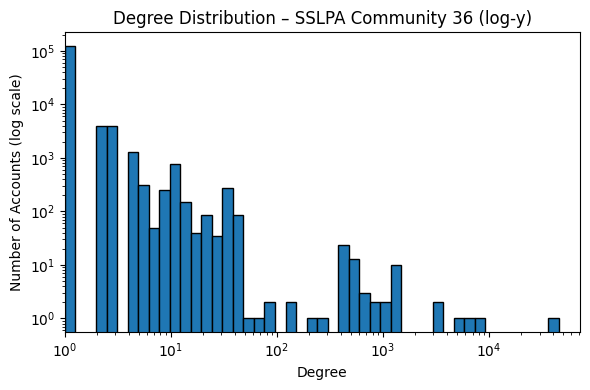

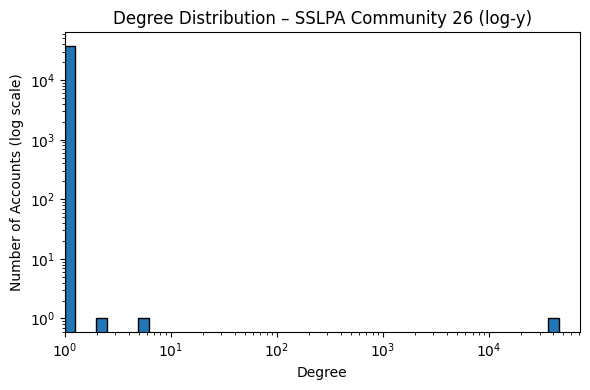

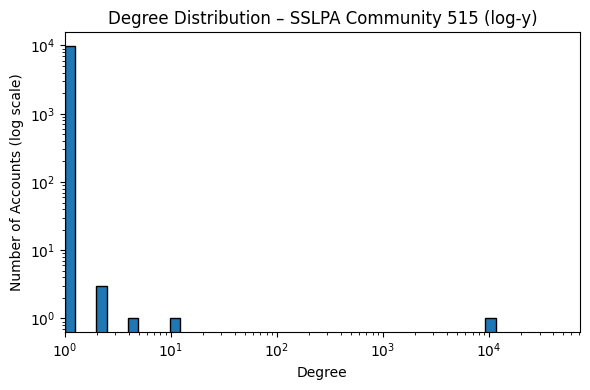

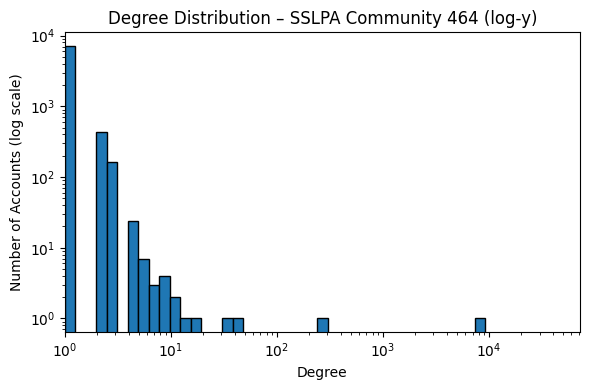

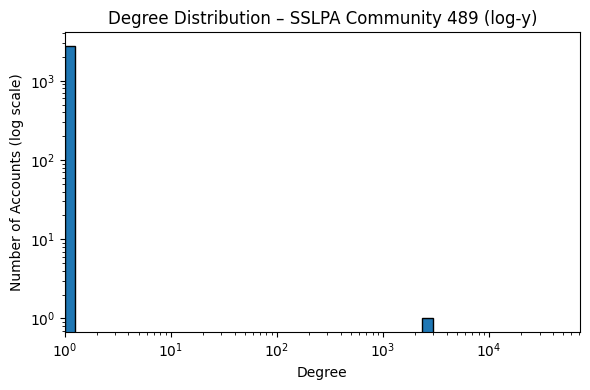

In [ ]:
import numpy as np

top5_ids = top5["community"].tolist()
print("Top-5 community IDs:", top5_ids)


all_degs = []
for community_id in top5_ids:
    comm_nodes = df_comm.loc[df_comm["community"] == community_id, "node"].tolist()
    comm_nodes_in_G = [n for n in comm_nodes if n in G]
    sub = G.subgraph(comm_nodes_in_G)
    degs = [d for _, d in sub.degree()]
    all_degs.extend(degs)

all_degs_pos = [d for d in all_degs if d > 0]
min_deg = min(all_degs_pos)
max_deg = max(all_degs_pos)

bins = np.logspace(np.log10(min_deg), np.log10(max_deg), 50)

for community_id in top5_ids:
    comm_nodes = df_comm.loc[df_comm["community"] == community_id, "node"].tolist()
    comm_nodes_in_G = [n for n in comm_nodes if n in G]
    sub = G.subgraph(comm_nodes_in_G)

    degs = [d for _, d in sub.degree()]
    degs_pos = [d for d in degs if d > 0]

    plt.figure(figsize=(6, 4))
    plt.hist(degs_pos, bins=bins, log=True, edgecolor="black")
    plt.xscale("log")  
    plt.xlim(min_deg, max_deg)

    plt.title(f"Degree Distribution – SSLPA Community {community_id} (log-y)")
    plt.xlabel("Degree")
    plt.ylabel("Number of Accounts (log scale)")
    plt.tight_layout()
    plt.show()


### Bind to metadata

In [11]:
NODES_CSV  = "~/stellar-clustering/network/data/new/account_nodes_all_mv.csv"
FEATS_CSV  = "~/stellar-clustering/network/data/new/account_node_features_full_mv.csv"

NODES_CSV = os.path.expanduser(NODES_CSV)
FEATS_CSV = os.path.expanduser(FEATS_CSV)

In [12]:
df_comm_raw = pd.read_csv(COMM_CSV)      
df_nodes = pd.read_csv(NODES_CSV)
df_meta = pd.read_csv(FEATS_CSV)

In [13]:
df_comm = df_comm_raw.rename(columns={"node": "account_id"})

df_merged = df_comm.merge(df_meta, on="account_id", how="left")
print(df_merged.head(10))



   account_id  community                                            address  \
0           5         36  GA3T4APSSIDE33RLUP5UKIIBDE6R6JQ2JOWAJ5JTKAZLP4...   
1         256         36  GBFEJG5NN5SLSYAUKYIMZJ7XOFQ7FHGQLWB3TE6IZSUFWS...   
2         746         36  GDG7ANN5DB5EDOJBF3ZWPXHZP2ONIP3NXAMXOXSXATQXEB...   
3        4671         36  GBQOHOHNJINMSK7LKHLQ3ATNRGQHVIHSQFMQ7DD7MKSSL7...   
4        4739         36  GCMOSWOH3HT3QDB4PNRDOD6SM767GPKIZJZX275RQ4EORZ...   
5        7701         36  GA6UWTE6DZJPPQ2NZ3TMCI5RI3A6YZUNRUV7ZTMVWAHHS3...   
6        7874         36  GBVXCF7H7J5VJ5JFB6IM2PUCYMYK4WKRJE7T7KTFULQAVY...   
7       58226         36  GBC6CFWXEVD2BWKB6GQV6ABMYUT5VSMSAPQBS4VDY2Z6CK...   
8      111593         36  GBZGQ4EUFWTUWH7ZY7RE4D2HQWFYM6IEJQPIQTANXC6EXH...   
9      111906         36  GC3GD24LK2N5BUW7GO3A52OBHFWE4TQPP2NWQ3EUICVJFI...   

       balance  threshold_high  flags  signer_count  n_trustlines  n_issuers  \
0  766310624.0             0.0    0.0             

In [ ]:
df_with_metadata = df_merged[df_merged["address"].notnull()]
overlap = df_comm["account_id"].isin(df_meta["account_id"]).sum()

In [15]:
output_path = "sslpa_tx_lcc_metadata.csv"
df_with_metadata.to_csv(output_path, index=False)
print(f"\nSaved {len(df_with_metadata)} records with metadata "
      f"({len(df_with_metadata)/len(df_merged)*100:.2f}%) to: {output_path}")


Saved 206451 records with metadata (100.00%) to: sslpa_tx_lcc_metadata.csv


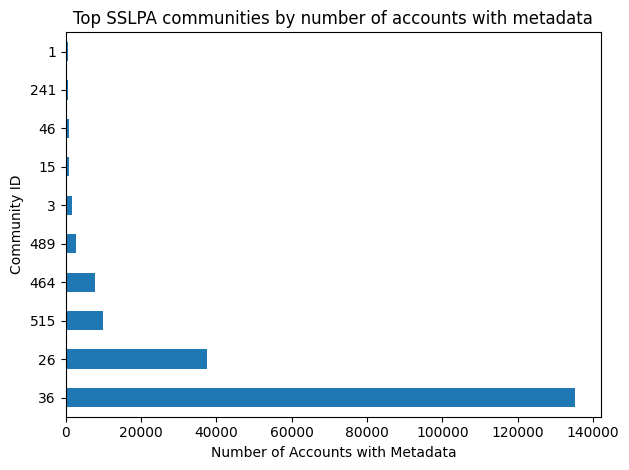

In [16]:
df_with_metadata["community"].value_counts().head(10).plot(
    kind="barh",
    title="Top SSLPA communities by number of accounts with metadata"
)
plt.xlabel("Number of Accounts with Metadata")
plt.ylabel("Community ID")
plt.tight_layout()
plt.show()

In [ ]:
NORM_LABELS = "~/stellar-clustering/network/labled-data/labels/label-normalization/labels_entities_normalized.csv"
df_norm = (
    pd.read_csv(NORM_LABELS)
      .dropna(subset=["account_id", "name"])
      .drop_duplicates(subset=["account_id"])
      .rename(columns={"name": "entity"})
)


try:
    df_comm["account_id"] = df_comm["account_id"].astype("Int64")
    df_norm["account_id"] = df_norm["account_id"].astype("Int64")
except Exception:
    df_comm["account_id"] = df_comm["account_id"].astype(str)
    df_norm["account_id"] = df_norm["account_id"].astype(str)

df_matched = df_comm.merge(df_norm, on="account_id", how="inner")

print(
    f"Matched normalized-labeled accounts: "
    f"{len(df_matched):,} / {len(df_comm):,} "
    f"({len(df_matched)/len(df_comm):.2%})"
)
df_matched.head()

Matched normalized-labeled accounts (SSLPA): 397 / 206,451 (0.19%)


,account_id,community,entity
0,2955,1,AQUA
1,270,36,SCAM
2,2197,36,SCAM
3,22229,36,SCAM
4,22565,36,SCAM


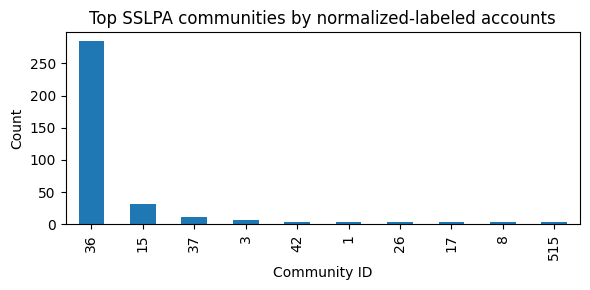

In [18]:
top_counts = df_matched["community"].value_counts().head(10)
ax = top_counts.plot(
    kind="bar",
    figsize=(6, 3),
    title="Top SSLPA communities by normalized-labeled accounts"
)
ax.set_xlabel("Community ID")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [19]:
label_counts = (
    df_matched
      .groupby(["community", "entity"])
      .size()
      .reset_index(name="count")
)


top_communities = (
    label_counts.groupby("community")["count"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
      .tolist()
)


table_top = (
    label_counts[label_counts["community"].isin(top_communities)]
    .sort_values(["count"], ascending=[False])
    .reset_index(drop=True)
)

display(table_top)


,community,entity,count
0,36,SCAM,284
1,15,Coinbase,32
2,37,SDF,11
3,3,Binance,6
4,42,TMM bot,4
5,1,AQUA,3
6,26,Lobstr,3
7,17,EXLM,3
8,8,Blockchain.com,3
9,515,UltraCapital,3


In [ ]:
label_counts = (
    df_matched
    .groupby(["community", "entity"])
    .size()
    .reset_index(name="count")
)

top_communities = (
    label_counts.groupby("community")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

comm_stats = []
for comm_id in top_communities:
    comm_nodes = df_comm[df_comm["community"] == comm_id]["account_id"].tolist()
    total_size = len(comm_nodes)
    
    labeled_in_comm = df_matched[df_matched["community"] == comm_id]
    num_labeled = len(labeled_in_comm)
    
    if num_labeled > 0:
        top_entity_name = labeled_in_comm["entity"].value_counts().index[0]
    else:
        top_entity_name = "N/A"
    
    comm_nodes_in_G = [n for n in comm_nodes if n in G]
    if comm_nodes_in_G:
        subG = G.subgraph(comm_nodes_in_G)
        edges = subG.number_of_edges()
        density = nx.density(subG)
        avg_degree = 2.0 * edges / len(comm_nodes_in_G) if len(comm_nodes_in_G) > 0 else 0
    else:
        edges = 0
        density = 0
        avg_degree = 0
    
    comm_stats.append({
        "community": comm_id,
        "total_size": total_size,
        "num_labeled": num_labeled,
        "labeled %": (num_labeled / total_size) * 100,
        "dominant_entity": top_entity_name,
        "edges": edges,
        "density": density,
        "avg_degree": avg_degree
    })

df_comm_stats = pd.DataFrame(comm_stats)

table_top = (
    label_counts[label_counts["community"].isin(top_communities)]
    .sort_values(["count"], ascending=[False])
    .reset_index(drop=True)
)

table_top_enhanced = table_top.merge(
    df_comm_stats, 
    on="community", 
    how="left"
)

column_order = [
    "community", 
    "entity", 
    "count",
    "total_size",
    "num_labeled",
    "labeled %",
    "dominant_entity",
    "edges",
    "density",
    "avg_degree"
]

table_top_enhanced = table_top_enhanced[column_order]

display(table_top_enhanced)



,community,entity,count,total_size,num_labeled,labeled %,dominant_entity,edges,density,avg_degree
0,36,SCAM,284,135290,284,0.209919,SCAM,178098,0.000019,2.632833
1,15,Coinbase,32,986,32,3.245436,Coinbase,1373,0.002827,2.784990
2,37,SDF,11,11,11,100.000000,SDF,0,0.000000,0.000000
3,3,Binance,6,1657,6,0.362100,Binance,2223,0.001620,2.683162
4,42,TMM bot,4,213,4,1.877934,TMM bot,212,0.009390,1.990610
5,1,AQUA,3,638,3,0.470219,AQUA,662,0.003258,2.075235
6,26,Lobstr,3,37434,3,0.008014,Lobstr,37431,0.000053,1.999840
7,17,EXLM,3,3,3,100.000000,EXLM,0,0.000000,0.000000
8,8,Blockchain.com,3,22,3,13.636364,Blockchain.com,19,0.082251,1.727273
9,515,UltraCapital,3,9847,3,0.030466,UltraCapital,9846,0.000203,1.999797


In [21]:
print("COMMUNITY-LEVEL SUMMARY (Top 10)")
display(df_comm_stats.sort_values("num_labeled", ascending=False))

COMMUNITY-LEVEL SUMMARY (Top 10)


,community,total_size,num_labeled,labeled %,dominant_entity,edges,density,avg_degree
0,36,135290,284,0.209919,SCAM,178098,0.000019,2.632833
1,15,986,32,3.245436,Coinbase,1373,0.002827,2.784990
2,37,11,11,100.000000,SDF,0,0.000000,0.000000
3,3,1657,6,0.362100,Binance,2223,0.001620,2.683162
4,42,213,4,1.877934,TMM bot,212,0.009390,1.990610
5,17,3,3,100.000000,EXLM,0,0.000000,0.000000
6,26,37434,3,0.008014,Lobstr,37431,0.000053,1.999840
7,1,638,3,0.470219,AQUA,662,0.003258,2.075235
8,8,22,3,13.636364,Blockchain.com,19,0.082251,1.727273
9,515,9847,3,0.030466,UltraCapital,9846,0.000203,1.999797


In [22]:
label_counts = (
    df_matched
      .groupby(["community", "entity"])
      .size()
      .reset_index(name="count")
)


In [ ]:
non_scam = label_counts[label_counts["entity"] != "SCAM"].copy()

if non_scam.empty:
    print("No non SCAM")
else:
    print("Non SCAM entity labels:")
    display(
        non_scam.sort_values(["count"], ascending=[False])
    )


Non SCAM entity labels:


,community,entity,count
15,15,Coinbase,32
37,37,SDF,11
3,3,Binance,6
42,42,TMM bot,4
8,8,Blockchain.com,3
26,26,Lobstr,3
17,17,EXLM,3
1,1,AQUA,3
47,519,Wirex,3
43,515,UltraCapital,3


In [24]:
df_comm = pd.read_csv(COMM_CSV).rename(columns={"node": "account_id"})


df_lbls = (
    pd.read_csv(SSLPA_LABELS)
      .rename(columns={"node": "account_id", "label": "sslpa_label"})
)

In [25]:

df_full = df_comm.merge(df_lbls, on="account_id", how="left")

df_full["is_unlab"] = df_full["sslpa_label"].astype(str).str.startswith("UNLAB_")
df_full["is_entity_label"] = ~df_full["is_unlab"]

In [26]:
total_nodes = len(df_full)
num_unlab = df_full["is_unlab"].sum()
num_propagated = df_full["is_entity_label"].sum()

print(f"Total nodes in SSLPA TX partition: {total_nodes:,}")
print(f"Nodes that remained UNLAB_*: {num_unlab:,} ({num_unlab/total_nodes:.2%})")
print(f"Nodes with propagated entity label: {num_propagated:,} ({num_propagated/total_nodes:.2%})")


Total nodes in SSLPA TX partition: 206,451
Nodes that remained UNLAB_*: 18,815 (9.11%)
Nodes with propagated entity label: 187,636 (90.89%)


In [27]:
df_lbls = pd.read_csv(SSLPA_LABELS)
df_lbls.head()

,node,label
0,5,SCAM
1,256,SCAM
2,746,SCAM
3,4671,SCAM
4,4739,SCAM


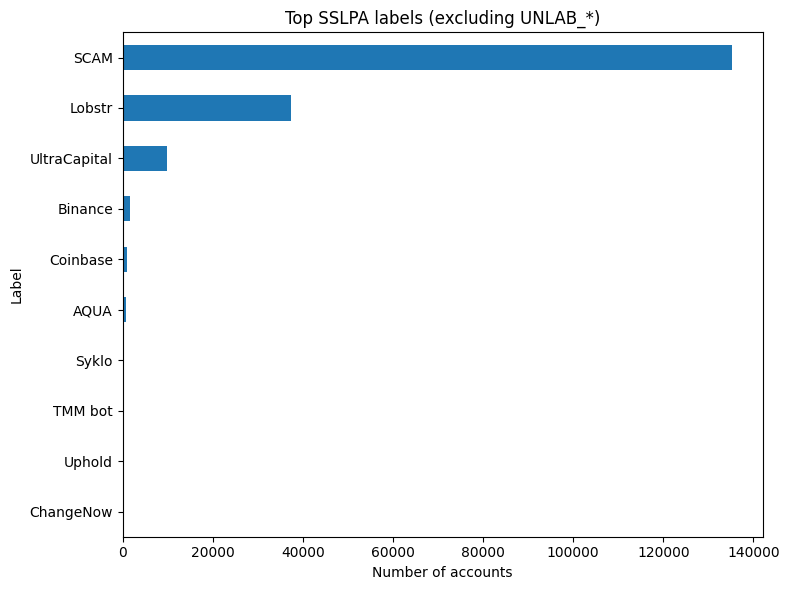

In [28]:
df_entities = df_lbls[~df_lbls["label"].astype(str).str.startswith("UNLAB_")]

top_labels = (
    df_entities["label"]
    .value_counts()
    .head(10)
)

top_labels = top_labels.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
ax = top_labels.plot(kind="barh")
ax.set_title("Top SSLPA labels (excluding UNLAB_*)")
ax.set_xlabel("Number of accounts")
ax.set_ylabel("Label")

plt.tight_layout()
plt.show()


In [29]:
# communities
df_comm = pd.read_csv(COMM_CSV).rename(columns={"node": "account_id"})
df_lbls = df_lbls.rename(columns={"node": "account_id", "label": "sslpa_label"})

df_full = df_comm.merge(df_lbls, on="account_id", how="left")

label_comm_counts = (
    df_full
      .groupby(["community", "sslpa_label"])
      .size()
      .reset_index(name="count")
)

label_comm_counts.sort_values("count", ascending=False).head(10)


,community,sslpa_label,count
36,36,SCAM,135290
26,26,Lobstr,37434
515,515,UltraCapital,9847
464,464,UNLAB_416,7775
489,489,UNLAB_6296927,2751
3,3,Binance,1657
15,15,Coinbase,986
46,46,UNLAB_10208,836
241,241,UNLAB_162762794,648
1,1,AQUA,638


In [30]:
df_comm = pd.read_csv(COMM_CSV).rename(columns={"node": "account_id"})
df_lbls = df_lbls.rename(columns={"node": "account_id", "label": "sslpa_label"})

df_full = df_comm.merge(df_lbls, on="account_id", how="left")

label_comm_counts = (
    df_full
    .groupby(["community", "sslpa_label"])
    .size()
    .reset_index(name="count")
)

top_communities = (
    label_comm_counts.groupby("community")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

comm_stats = []
for comm_id in top_communities:
    comm_nodes = df_comm[df_comm["community"] == comm_id]["account_id"].tolist()
    total_size = len(comm_nodes)
    
    labeled_in_comm = df_full[df_full["community"] == comm_id].copy()
    num_with_label = len(labeled_in_comm[labeled_in_comm["sslpa_label"].notna()])
    
    labeled_in_comm["is_unlab"] = labeled_in_comm["sslpa_label"].astype(str).str.startswith("UNLAB_")
    num_entity_labels = labeled_in_comm[~labeled_in_comm["is_unlab"]].shape[0]
    num_unlab = labeled_in_comm[labeled_in_comm["is_unlab"]].shape[0]
    
    if num_with_label > 0:
        top_label = labeled_in_comm["sslpa_label"].value_counts().index[0]
    else:
        top_label = "N/A"
    
    comm_nodes_in_G = [n for n in comm_nodes if n in G]
    if comm_nodes_in_G:
        subG = G.subgraph(comm_nodes_in_G)
        edges = subG.number_of_edges()
        density = nx.density(subG)
        avg_degree = 2.0 * edges / len(comm_nodes_in_G) if len(comm_nodes_in_G) > 0 else 0
    else:
        edges = 0
        density = 0
        avg_degree = 0
    
    comm_stats.append({
        "community": comm_id,
        "total_size": total_size,
        "num_entity_labels": num_entity_labels,
        "num_unlab": num_unlab,
        "dominant_label": top_label,
        "edges": edges,
        "density": density,
        "avg_degree": avg_degree
    })

df_comm_stats = pd.DataFrame(comm_stats)

table_top = (
    label_comm_counts[label_comm_counts["community"].isin(top_communities)]
    .sort_values(["count"], ascending=[False])
    .reset_index(drop=True)
)

table_top_enhanced = table_top.merge(
    df_comm_stats, 
    on="community", 
    how="left"
)

column_order = [
    "community", 
    "sslpa_label", 
    "count",
    "total_size",
    "num_entity_labels",
    "num_unlab",
    "dominant_label",
    "edges",
    "density",
    "avg_degree"
]

table_top_enhanced = table_top_enhanced[column_order]

display(table_top_enhanced)



,community,sslpa_label,count,total_size,num_entity_labels,num_unlab,dominant_label,edges,density,avg_degree
0,36,SCAM,135290,135290,135290,0,SCAM,178098,0.000019,2.632833
1,26,Lobstr,37434,37434,37434,0,Lobstr,37431,0.000053,1.999840
2,515,UltraCapital,9847,9847,9847,0,UltraCapital,9846,0.000203,1.999797
3,464,UNLAB_416,7775,7775,0,7775,UNLAB_416,8258,0.000273,2.124244
4,489,UNLAB_6296927,2751,2751,0,2751,UNLAB_6296927,2750,0.000727,1.999273
5,3,Binance,1657,1657,1657,0,Binance,2223,0.001620,2.683162
6,15,Coinbase,986,986,986,0,Coinbase,1373,0.002827,2.784990
7,46,UNLAB_10208,836,836,0,836,UNLAB_10208,1536,0.004401,3.674641
8,241,UNLAB_162762794,648,648,0,648,UNLAB_162762794,647,0.003086,1.996914
9,1,AQUA,638,638,638,0,AQUA,662,0.003258,2.075235
